<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/driver_action_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#Authorize Google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#download train and test images
download = drive.CreateFile({'id': '1UPt8uX_wHzSplanU7zhGVDjsYpVMNikz'})
download.GetContentFile('state-farm-distracted-driver-detection.zip')

#Extract files
zip_ref = zipfile.ZipFile('state-farm-distracted-driver-detection.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [7]:
from keras.utils import to_categorical

def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  resized = cv2.resize(img, (w,h), cv2.INTER_LINEAR) 
  return resized

TRAINING_DIR = 'tmp/imgs/train'
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

files = []
categories = []
paths = []

for i in range(10):
  for file in os.listdir("%s/c%s" %(TRAINING_DIR, i)):
    files.append(file)
    categories.append(i)
    paths.append("%s/c%s/%s" %(TRAINING_DIR, i, file))

df = pd.DataFrame({'file': files,
                   'category': categories,
                   'path': paths
                  })

df['Y'] = df['category'].map(lambda x: to_categorical(x, 10, dtype='uint8'))
df['X'] = df['path'].map(lambda path: get_im_cv2(path, IMAGE_WIDTH, IMAGE_HEIGHT))
df.sample(5, axis=None)

,file,category,path,Y,X
22093,img_49712.jpg,9,tmp/imgs/train/c9/img_49712.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[[[19, 46, 30], [28, 42, 29], [27, 41, 30], [2..."
21399,img_39144.jpg,9,tmp/imgs/train/c9/img_39144.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[[[30, 49, 27], [40, 48, 34], [37, 45, 39], [3..."
11525,img_97353.jpg,4,tmp/imgs/train/c4/img_97353.jpg,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[[[41, 50, 37], [39, 48, 35], [39, 49, 36], [4..."
21069,img_24621.jpg,9,tmp/imgs/train/c9/img_24621.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[[[60, 73, 61], [62, 74, 62], [63, 76, 64], [6..."
6327,img_85211.jpg,2,tmp/imgs/train/c2/img_85211.jpg,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[[[31, 37, 33], [30, 37, 32], [28, 35, 30], [2..."


In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

x_train = []
x_test = []
y_train = []
y_test= []

for item in train_df['X']:
  x_train.append(item)

for item in validate_df['X']:
  x_test.append(item)

for item in train_df['Y']:
  y_train.append(item)

for item in validate_df['Y']:
  y_test.append(item)

x_train = np.array(x_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

In [9]:
#build model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # 

for layer in base_model.layers:
    layer.trainable = False

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

## Train
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input

earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
EPOCHS=5
BATCH_SIZE=15
callbacks = [learning_rate_reduction]

history = model.fit(x_train, 
                    y_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test)
                    ,callbacks=callbacks)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_101 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

In [10]:
TEST_DIRECTORY = 'tmp/imgs/test/'
test_data = pd.DataFrame({'filename': os.listdir(TEST_DIRECTORY)})

test_data_frame = test_data[0:20]
test_data_frame['X'] = test_data_frame['filename'].map(lambda file: get_im_cv2(TEST_DIRECTORY + "/" + file, IMAGE_WIDTH, IMAGE_HEIGHT))

x_perf=[]
for item in test_data_frame['X']:
  x_perf.append(item)

x_perf = np.array(x_perf, dtype=np.uint8)
predict = model.predict(x_perf)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


        filename  ...                       action
0  img_32642.jpg  ...  talking on the phone - left
1  img_61933.jpg  ...                     drinking
2  img_20280.jpg  ...              reaching behind
3  img_83278.jpg  ...              reaching behind
4  img_40311.jpg  ...              reaching behind

[5 rows x 4 columns]


ValueError: ignored

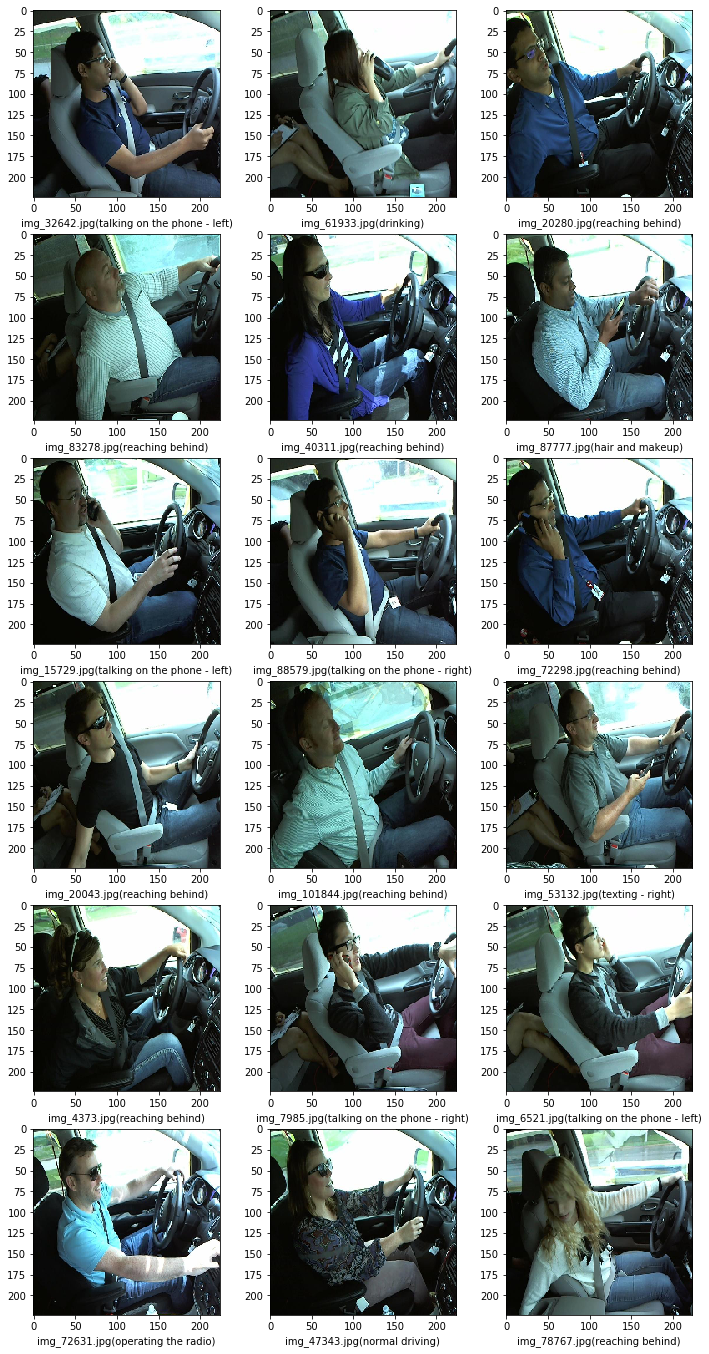

In [14]:
#Plot prediction
import matplotlib.pyplot as plt
label_map = {
    0: "normal driving",
    1: "texting - right",
    2: "talking on the phone - right",
    3: "texting - left",
    4: "talking on the phone - left",
    5: "operating the radio",
    6: "drinking",
    7: "reaching behind",
    8: "hair and makeup",
    9: "talking to passenger"
}

test_data_frame['category'] = np.argmax(predict, axis=1)
test_data_frame['action'] = test_data_frame['category'].map(lambda x: label_map.get(x))
print(test_data_frame.head())

#Draw predictions with images
from keras.preprocessing.image import load_img
sample_test = test_data_frame
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['action']
    img = load_img(TEST_DIRECTORY+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
